In [1]:
import yfinance as yf
from datetime import datetime, date, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import scipy.optimize as spop
import QuantLib as ql
from scipy.optimize import minimize
import math
from scipy.stats import norm

In [2]:
# Inputs
ticker = 'SPY'
end_date = date.today()
start_date = end_date - timedelta(days=3*365)
start_date = start_date.strftime('%Y-%m-%d')

[*********************100%%**********************]  1 of 1 completed


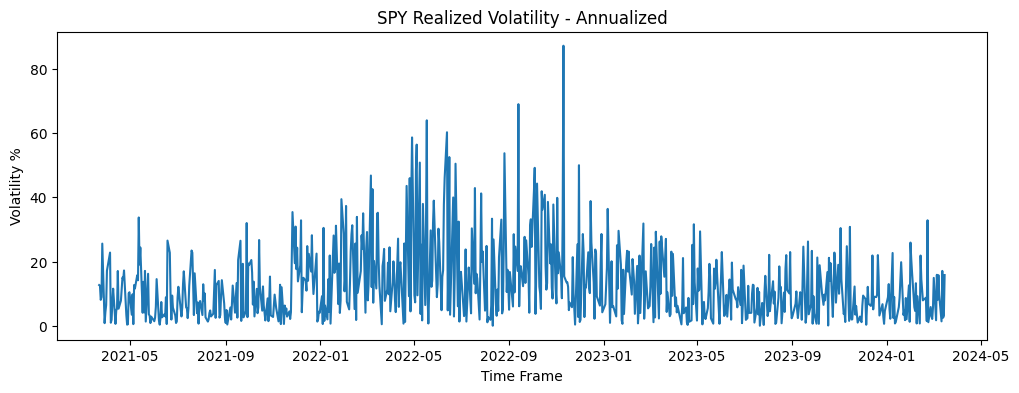

In [3]:
prices = yf.download(ticker, start_date, end_date)['Close']
returns = 100 * (prices.pct_change().dropna())
mean = np.average(returns)
var = np.std(returns)**2
trading_day_count = np.busday_count(start_date, end_date)

def realized_volatility(returns):
    realized = np.abs(returns)
    return realized

realized = realized_volatility(returns)

annualized_volatility = np.sqrt(252) * realized

plt.figure(figsize=(12,4))
plt.plot(annualized_volatility)
plt.xlabel('Time Frame')
plt.ylabel('Volatility %')
plt.title(f'{ticker} Realized Volatility - Annualized')
plt.show()

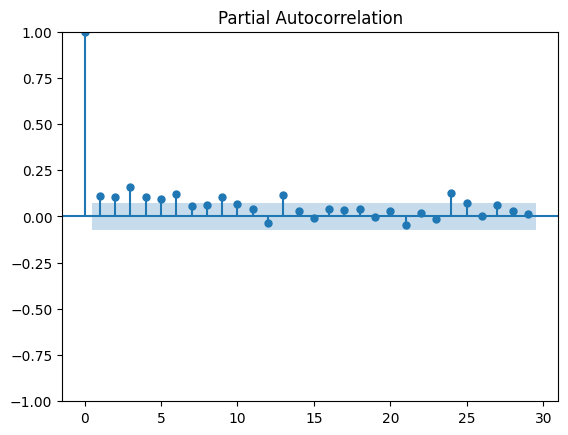

In [4]:
plot_pacf(returns**2)
plt.show()

In [5]:
# Fit Model
p = 2
q = 0

model = arch_model(returns, p=p, q=q)
model_fit = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3728.3071838100004
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2275.4772010243187
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1840.2059002815786
Iteration:      4,   Func. Count:     29,   Neg. LLF: 3447.7094271165624
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1139.4922183196215
Iteration:      6,   Func. Count:     41,   Neg. LLF: 18101.671304943502
Iteration:      7,   Func. Count:     47,   Neg. LLF: 1107.7541467257522
Iteration:      8,   Func. Count:     53,   Neg. LLF: 1107.6453033135724
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1107.6431479195758
Iteration:     10,   Func. Count:     63,   Neg. LLF: 1107.6430249129662
Iteration:     11,   Func. Count:     68,   Neg. LLF: 1107.6430237460563
Iteration:     12,   Func. Count:     72,   Neg. LLF: 1107.6430237460754
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1107.6430237460563
            Ite

In [6]:
model_fit.summary()
print("Total Trading Days:", trading_day_count)

Total Trading Days: 781


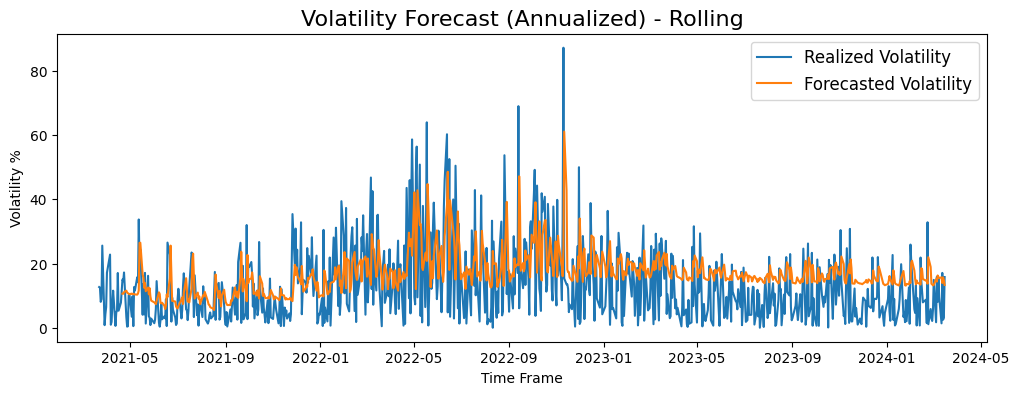

In [7]:
rolling_forecast = []

# test size should be Total Trading Days - 50 or 100
test_size = trading_day_count - 50

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, p=p, q=q)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_forecast.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_forecast = pd.Series(rolling_forecast, index=returns.index[-test_size:])
annualized_forecast = np.sqrt(252) * rolling_forecast

plt.figure(figsize=(12,4))
true, = plt.plot(annualized_volatility)
preds, = plt.plot(annualized_forecast)
plt.title('Volatility Forecast (Annualized) - Rolling', fontsize=16)
plt.xlabel('Time Frame')
plt.ylabel('Volatility %')
plt.legend(['Realized Volatility', 'Forecasted Volatility'], fontsize=12)

Text(0.5, 1.0, 'Volatility Forecast - 7 Day')

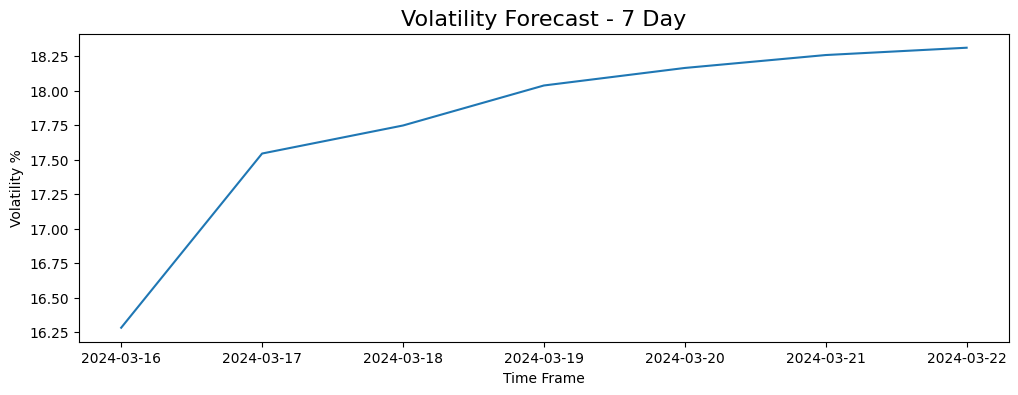

In [8]:
#Input
hzn = 7

train = returns
model = arch_model(train, p=p, q=q)
model_fit = model.fit(disp='off')
pred = model_fit.forecast(horizon=hzn)
future_dates = [returns.index[-1] + timedelta(days=i) for i in range(1,hzn+1)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)
annualized_pred = np.sqrt(252) * pred

plt.figure(figsize=(12,4))
plt.plot(annualized_pred)
plt.xlabel('Time Frame')
plt.ylabel('Volatility %')
plt.title(f'Volatility Forecast - {hzn} Day', fontsize=16)